# California Wildfire Risk Analysis
### Data Preparation Pipeline
    This script prepares climate, wildfire, and vegetation data for analysis.
    All data processing steps are carefully documented and validated.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from rtree import index
from datetime import datetime, timedelta
import contextily as ctx
import folium
from collections import defaultdict
import os

In [2]:
from shapely.validation import explain_validity

In [3]:
from shapely.geometry import Point
from shapely.ops import transform
import pyproj
from functools import partial
import logging

In [4]:
# Set path
path = r'/media/scruffy/Elements/python_data/Final'

In [59]:
# Load ERA5 weather history
df15 = pd.read_csv(os.path.join(path, 'Original Data', 'era5_2015.csv'))
df16 = pd.read_csv(os.path.join(path, 'Original Data', 'era5_2016.csv'))
df17 = pd.read_csv(os.path.join(path, 'Original Data', 'era5_2017.csv'))
df18 = pd.read_csv(os.path.join(path, 'Original Data', 'era5_2018.csv'))
df19 = pd.read_csv(os.path.join(path, 'Original Data', 'era5_2019.csv'))
df20 = pd.read_csv(os.path.join(path, 'Original Data', 'era5_2020.csv'))
df21 = pd.read_csv(os.path.join(path, 'Original Data', 'era5_2021.csv'))

In [16]:
df = pd.read_csv(os.path.join(path, 'Original Data', 'era5_2021.csv'))

In [ ]:
# Concatenate DataFrames
df = pd.concat([df15, df16, df17, df18, df19, df20, df21], ignore_index=True)

In [5]:
# Load CAL FIRE burn records
fire_gdf = gpd.read_file(r"/home/scruffy/anaconda_projects/final/02 Data/Original Data/fire24_1.gdb", layer=1)

/home/scruffy/anaconda3/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [6]:
# Load Normalized Difference Vegetation Index
ndvi_df = pd.read_csv(os.path.join(path, 'Original Data', 'modis_ndvi.csv'))

In [128]:
# Load DEM
dem_df = pd.read_csv(os.path.join(path, 'Original Data',  'nasadem.csv'))

In [7]:
points = pd.read_csv(os.path.join(path, 'Prepared Data', 'era5_sample_points_coordinates.csv'))

# Consistency Checks & Cleaning

## Climate Data

In [63]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693800 entries, 0 to 8693799
Data columns (total 17 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   date                               object 
 1   longitude                          float64
 2   latitude                           float64
 3   temperature_2m                     float64
 4   temperature_2m_max                 float64
 5   total_precipitation_sum            float64
 6   dewpoint_temperature_2m            float64
 7   u_component_of_wind_10m            float64
 8   v_component_of_wind_10m            float64
 9   volumetric_soil_water_layer_1      float64
 10  surface_net_solar_radiation_sum    float64
 11  surface_net_thermal_radiation_sum  float64
 12  surface_sensible_heat_flux_sum     float64
 13  potential_evaporation_sum          float64
 14  total_evaporation_sum              float64
 15  leaf_area_index_high_vegetation    float64
 16  leaf_area_index_lo

In [64]:
# Get date as datetime
df['date'] = pd.to_datetime(df['date'])

In [65]:
df.isna().sum()

date                                     0
longitude                                0
latitude                                 0
temperature_2m                       94609
temperature_2m_max                   94609
total_precipitation_sum              94609
dewpoint_temperature_2m              94609
u_component_of_wind_10m              94609
v_component_of_wind_10m              94609
volumetric_soil_water_layer_1        94609
surface_net_solar_radiation_sum      86210
surface_net_thermal_radiation_sum    94609
surface_sensible_heat_flux_sum       94609
potential_evaporation_sum            94609
total_evaporation_sum                94609
leaf_area_index_high_vegetation      94609
leaf_area_index_low_vegetation       94609
dtype: int64

In [ ]:
df = df.dropna()

In [70]:
df.describe()

,date,longitude,latitude,temperature_2m,temperature_2m_max,total_precipitation_sum,dewpoint_temperature_2m,u_component_of_wind_10m,v_component_of_wind_10m,volumetric_soil_water_layer_1,surface_net_solar_radiation_sum,surface_net_thermal_radiation_sum,surface_sensible_heat_flux_sum,potential_evaporation_sum,total_evaporation_sum,leaf_area_index_high_vegetation,leaf_area_index_low_vegetation
count,8599191,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06,8.599191e+06
mean,2018-07-01 23:59:59.999999744,-1.190286e+02,3.638924e+01,2.896188e+02,2.963091e+02,1.279169e-03,2.760331e+02,5.784303e-01,6.653560e-02,1.762797e-01,1.639825e+07,-8.743213e+06,-5.255708e+06,-1.088731e-02,-9.214842e-04,2.021211e+00,1.251342e+00
min,2015-01-01 00:00:00,-1.240490e+02,3.254954e+01,2.520619e+02,2.562904e+02,-4.841513e-08,2.414853e+02,-9.465885e+00,-1.238456e+01,-1.652928e-20,2.433920e+05,-1.960402e+07,-2.158004e+07,-1.094246e-01,-1.635782e-02,0.000000e+00,0.000000e+00
25%,2016-10-01 00:00:00,-1.208490e+02,3.474949e+01,2.832620e+02,2.891731e+02,8.289023e-07,2.714929e+02,-1.842089e-01,-7.002554e-01,4.135386e-02,1.069568e+07,-1.072793e+07,-8.325544e+06,-1.265242e-02,-1.351830e-03,0.000000e+00,5.156250e-01
50%,2018-07-02 00:00:00,-1.191489e+02,3.624933e+01,2.891884e+02,2.961334e+02,1.708582e-06,2.767967e+02,4.823456e-01,2.797381e-02,1.376101e-01,1.690140e+07,-8.800972e+06,-4.806664e+06,-7.809184e-03,-6.644819e-04,2.131933e+00,1.050903e+00
75%,2020-04-01 00:00:00,-1.170489e+02,3.804918e+01,2.962362e+02,3.038641e+02,7.216930e-05,2.812523e+02,1.232651e+00,8.688655e-01,2.805926e-01,2.229932e+07,-6.859618e+06,-1.731744e+06,-4.085623e-03,-1.715831e-04,3.123154e+00,1.953985e+00
max,2021-12-31 00:00:00,-1.142489e+02,4.014913e+01,3.205549e+02,3.246405e+02,1.422542e-01,2.978255e+02,1.355229e+01,1.010364e+01,7.524459e-01,3.133977e+07,2.232711e+06,3.205590e+07,1.148686e-03,1.968028e-03,5.439443e+00,3.427277e+00
std,NaN,2.365146e+00,2.000735e+00,9.214812e+00,9.969115e+00,5.331762e-03,7.097905e+00,1.212460e+00,1.389828e+00,1.398885e-01,6.719253e+06,3.111605e+06,4.171959e+06,1.050054e-02,9.204945e-04,1.583260e+00,8.710262e-01


In [76]:
df_dups = df[df.duplicated(subset=['dewpoint_temperature_2m', 'temperature_2m'])]
df_dups.shape

(0, 17)

In [ ]:
# Set test date for visualization
test_date = df[df['date']=='2017-07-07']

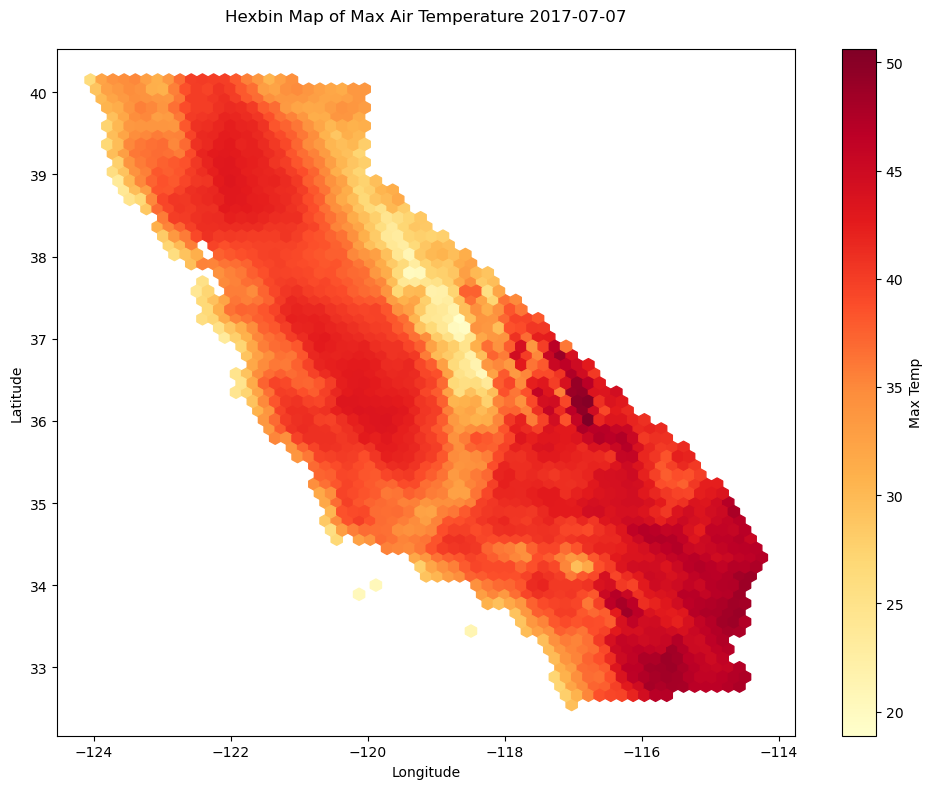

In [237]:
# Create figure
plt.figure(figsize=(10, 8))

# Create hexbin plot
hb = plt.hexbin(
    x=test_date['longitude'],
    y=test_date['latitude'],
    C=test_date['temperature_2m_max'],
    gridsize=60,
    cmap='YlOrRd',
    reduce_C_function=np.max,  # Show average max air temp per hexagon
    mincnt=1  # Show hexagons with at least 1 point
)

# Add colorbar
cb = plt.colorbar(hb, label='Max Temp')

# Customize plot
plt.title('Hexbin Map of Max Air Temperature 2017-07-07', pad=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust layout and show
plt.tight_layout()
plt.show()

In [68]:
# Complete date range
start_date = df['date'].min()
end_date = df['date'].max()
complete_range = pd.date_range(start=start_date, end=end_date, freq='D')
print(complete_range[0], '-', complete_range.sort_values(ascending=False)[0])

2015-01-01 00:00:00 - 2021-12-31 00:00:00


In [77]:
# Find missing dates
missing_dates = complete_range.difference(df['date'])
print(missing_dates.shape)
print(missing_dates)

(0,)
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


### Feature Processing

In [80]:
# Convert temperature from Kelvin to Celsius
df['temperature_2m_max'] = (df['temperature_2m_max'] - 273.15)
df['temperature_2m'] = (df['temperature_2m'] - 273.15)
df['dewpoint_temperature_2m'] = (df['dewpoint_temperature_2m'] - 273.15)

# Convert precipitation from m to mm
df['total_precipitation_sum'] = df['total_precipitation_sum']*1000

# Calculate windspeed and direction
df['max_windspeed'] = np.sqrt((df['u_component_of_wind_10m']**2)+(df['v_component_of_wind_10m']**2))
df['wind_direction'] = np.arctan2((df['v_component_of_wind_10m']),(df['u_component_of_wind_10m']))*180/np.pi
# Delete redundant columns
df.drop(columns=['u_component_of_wind_10m', 'v_component_of_wind_10m'], inplace=True)

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8599191 entries, 0 to 8693799
Data columns (total 17 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   date                               datetime64[ns]
 1   longitude                          float64       
 2   latitude                           float64       
 3   temperature_2m                     float64       
 4   temperature_2m_max                 float64       
 5   total_precipitation_sum            float64       
 6   dewpoint_temperature_2m            float64       
 7   volumetric_soil_water_layer_1      float64       
 8   surface_net_solar_radiation_sum    float64       
 9   surface_net_thermal_radiation_sum  float64       
 10  surface_sensible_heat_flux_sum     float64       
 11  potential_evaporation_sum          float64       
 12  total_evaporation_sum              float64       
 13  leaf_area_index_high_vegetation    float64       
 14  leaf_ar

In [83]:
df.to_csv(os.path.join(path, 'Prepared Data', 'era5.csv'))

## Fire Data 

In [6]:
def geometry_reviewer(object):
    """
    Simple function that returns output of shapely validation check
    ----------

    Returns
    -------
    <string>
      shapely output
    """  
    return explain_validity(object)

In [7]:
# Key table to convert cause codes to names
cause_code = pd.read_csv(os.path.join(path, 'Original Data', 'cause_code.csv'))

In [8]:
print(f"\nCRS: {fire_gdf.crs}\n")
fire_gdf.info()

CRS: EPSG:3310
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22810 entries, 0 to 22809
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   YEAR_         22733 non-null  float64            
 1   STATE         22810 non-null  object             
 2   AGENCY        22761 non-null  object             
 3   UNIT_ID       22749 non-null  object             
 4   FIRE_NAME     22748 non-null  object             
 5   INC_NUM       21839 non-null  object             
 6   IRWINID       3736 non-null   object             
 7   ALARM_DATE    17414 non-null  datetime64[ms, UTC]
 8   CONT_DATE     10180 non-null  datetime64[ms, UTC]
 9   C_METHOD      10708 non-null  float64            
 10  CAUSE         22810 non-null  int16              
 11  COMPLEX_NAME  611 non-null    object             
 12  COMPLEX_ID    567 non-null    object             
 13  OBJECTIVE     22539 non-null  float64 

In [9]:
fire_gdf = fire_gdf.merge(cause_code, on='CAUSE', how='left')

In [10]:
print(f"\nFires by Cause: \n")
print(fire_gdf['cause_name'].value_counts())


Fires by Cause: 

cause_name
Unknown/Unidentified                      10316
Lightning                                  3548
Misc                                       3507
Equipment Use                              1391
Arson                                       987
Debris                                      782
Vehicle                                     597
Powerline                                   480
Campfire                                    418
Smoking                                     341
Playing with Fire (Formerly children?)      197
Escaped Prescribed Burn                     104
Railroad                                     79
Structure                                    30
Aircraft                                     15
Firefighter Training                          5
Name: count, dtype: int64


In [11]:
print(f"\nAverage Size of Fires by Cause:\n")
print(fire_gdf.groupby('cause_name')['GIS_ACRES'].mean().sort_values(ascending=False))


Average Size of Fires by Cause:

cause_name
Powerline                                 3633.777832
Campfire                                  3315.454834
Lightning                                 3254.745117
Arson                                     2461.509277
Misc                                      2352.169922
Aircraft                                  2309.328125
Unknown/Unidentified                      1435.166504
Equipment Use                             1388.363770
Vehicle                                   1228.123291
Railroad                                  1165.914062
Smoking                                   1032.528442
Debris                                     849.214172
Playing with Fire (Formerly children?)     671.262695
Firefighter Training                       594.019958
Escaped Prescribed Burn                    561.465576
Structure                                  319.322296
Name: GIS_ACRES, dtype: float32


In [12]:
fire_gdf.isna().sum()

YEAR_              77
STATE               0
AGENCY             49
UNIT_ID            61
FIRE_NAME          62
INC_NUM           971
IRWINID         19074
ALARM_DATE       5396
CONT_DATE       12630
C_METHOD        12102
CAUSE               0
COMPLEX_NAME    22199
COMPLEX_ID      22243
OBJECTIVE         271
GIS_ACRES           0
COMMENTS        19975
FIRE_NUM         5168
Shape_Length        0
Shape_Area          0
geometry            0
cause_name         13
cause_src          13
dtype: int64

In [13]:
# Find fires where alarm date is after containment date
baddates = fire_gdf['ALARM_DATE'] > fire_gdf['CONT_DATE']
fire_gdf[baddates]

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,...,COMPLEX_ID,OBJECTIVE,GIS_ACRES,COMMENTS,FIRE_NUM,Shape_Length,Shape_Area,geometry,cause_name,cause_src
2941,2017.0,CA,USF,PNF,SQUIRREL,00001273,{B63EACE9-A8C8-47E8-A19F-D2500BD15827},2017-09-27 00:00:00+00:00,2017-08-29 00:00:00+00:00,6.0,...,None,1.0,113.054428,None,None,3117.391696,4.575150e+05,"MULTIPOLYGON (((-7.87e+04 2.21e+05, -7.87e+04 ...",Arson,Human
3925,2015.0,CA,CCO,VNC,PALM,00016943,None,2015-12-03 00:00:00+00:00,2015-03-13 00:00:00+00:00,7.0,...,None,1.0,22.354658,3 spots poorly located and not included,,1786.824630,9.046609e+04,"MULTIPOLYGON (((6.46e+04 -4.08e+05, 6.46e+04 -...",Unknown/Unidentified,Unknown
3976,2015.0,CA,CCO,VNC,PERKIN,053255,None,2015-11-08 00:00:00+00:00,2015-08-13 00:00:00+00:00,6.0,...,None,1.0,9.354076,None,,1023.212504,3.785461e+04,"MULTIPOLYGON (((7.4e+04 -4.2e+05, 7.39e+04 -4....",Unknown/Unidentified,Unknown
4731,2012.0,CA,LRA,LAC,HILLSIDE,00003279,None,2012-07-03 00:00:00+00:00,2012-03-07 00:00:00+00:00,6.0,...,None,1.0,47.195267,"37851 MAGNOLIA LN, PLMD",None,1893.645278,1.909925e+05,"MULTIPOLYGON (((1.63e+05 -3.8e+05, 1.63e+05 -3...",Misc,Unknown
4807,2012.0,CA,USF,SNF,SUMMIT,00000002,None,2012-09-04 00:00:00+00:00,2012-04-22 00:00:00+00:00,6.0,...,None,1.0,14.658398,None,None,961.392051,5.932043e+04,"MULTIPOLYGON (((5.83e+04 -7.03e+04, 5.83e+04 -...",Debris,Human
6887,2005.0,CA,CCO,LAC,SIERRA,00149034,None,2005-07-13 00:00:00+00:00,2005-04-14 00:00:00+00:00,8.0,...,None,1.0,364.378601,None,00000000,9873.850272,1.474588e+06,"MULTIPOLYGON (((1.75e+05 -3.87e+05, 1.75e+05 -...",Playing with Fire (Formerly children?),Human
6976,2005.0,CA,USF,BDF,BARTON,00000000,None,2005-11-16 00:00:00+00:00,2005-07-07 00:00:00+00:00,2.0,...,None,1.0,69.785156,None,00000049,2718.929044,2.824105e+05,"MULTIPOLYGON (((2.87e+05 -4.23e+05, 2.87e+05 -...",Lightning,Natural
7007,2005.0,CA,USF,STF,HIGHLAND,None,None,2005-09-27 00:00:00+00:00,2005-06-11 00:00:00+00:00,1.0,...,None,2.0,43.213993,20090305,00000050,3906.392914,1.748808e+05,"MULTIPOLYGON (((-2.77e+03 4.14e+04, -2.77e+03 ...",Lightning,Natural
7034,2005.0,CA,USF,LNF,ROCKY,00000000,None,2005-09-16 00:00:00+00:00,2005-09-15 00:00:00+00:00,1.0,...,None,1.0,24.130497,None,00000032,1729.625220,9.765266e+04,"MULTIPOLYGON (((-1.35e+05 3.28e+05, -1.35e+05 ...",Misc,Unknown
7328,2004.0,CA,USF,TNF,LOWELL,00000000,None,2004-11-24 00:00:00+00:00,2004-11-21 00:00:00+00:00,6.0,...,None,1.0,16.969212,None,00000113,1013.193936,6.867196e+04,"MULTIPOLYGON (((-6.51e+04 1.41e+05, -6.51e+04 ...",Debris,Human


In [15]:
# Swap dates for other rows
fire_gdf.loc[baddates, ['ALARM_DATE', 'CONT_DATE']] = fire_gdf.loc[baddates, ['CONT_DATE', 'ALARM_DATE']].values

In [19]:
# All but one date appear to have alarm date and cont date swapped
# Correct year of Kibbie Fire
fire_gdf.loc[12996, 'ALARM_DATE'] = pd.to_datetime('1978-08-08 00:00:00', utc=True)
fire_gdf.loc[12996, 'CONT_DATE'] = pd.to_datetime('1978-11-10 00:00:00', utc=True)
fire_gdf.iloc[12996]

YEAR_                                                      1978.0
STATE                                                          CA
AGENCY                                                        USF
UNIT_ID                                                       STF
FIRE_NAME                                                  KIBBIE
INC_NUM                                                      None
IRWINID                                                      None
ALARM_DATE                              1978-08-08 00:00:00+00:00
CONT_DATE                               1978-11-10 00:00:00+00:00
C_METHOD                                                      6.0
CAUSE                                                           1
COMPLEX_NAME                                                 None
COMPLEX_ID                                                   None
OBJECTIVE                                                     1.0
GIS_ACRES                                              227.878357
COMMENTS  

In [20]:
fire_gdf[fire_gdf['ALARM_DATE'] > fire_gdf['CONT_DATE']]

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,...,COMPLEX_ID,OBJECTIVE,GIS_ACRES,COMMENTS,FIRE_NUM,Shape_Length,Shape_Area,geometry,cause_name,cause_src


In [21]:
# Create a "days to containment' measure
fire_gdf['days_to_containment'] = (fire_gdf['CONT_DATE']-fire_gdf['ALARM_DATE'])

In [22]:
# Look for unreasonable values
long_fires = fire_gdf['days_to_containment'] > '200 days'
fire_gdf[long_fires]

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,IRWINID,ALARM_DATE,CONT_DATE,C_METHOD,...,OBJECTIVE,GIS_ACRES,COMMENTS,FIRE_NUM,Shape_Length,Shape_Area,geometry,cause_name,cause_src,days_to_containment
1163,2021.0,CA,CDF,MVU,SOUTHERN,00007992,{4F0C331F-A20F-4949-8CBE-4F2717DD02DA},2021-05-02 00:00:00+00:00,2022-05-06 00:00:00+00:00,7.0,...,1.0,5365.901855,Power tools,None,46656.289969,2.171503e+07,"MULTIPOLYGON (((3.33e+05 -5.54e+05, 3.33e+05 -...",Equipment Use,Human,369 days
1341,2021.0,CA,CDF,FKU,TIVY,00014330,{38348C8F-C001-4F2C-801D-01B10DA0C52B},2021-09-07 00:00:00+00:00,2022-09-07 00:00:00+00:00,1.0,...,1.0,25.031429,None,None,1905.579127,1.012986e+05,"MULTIPOLYGON (((5.51e+04 -1.38e+05, 5.51e+04 -...",Equipment Use,Human,365 days
2465,2018.0,CA,CDF,SHU,GORGE,00008796,{A4507E4F-0145-4F87-8038-3F73A8FD5E20},2018-08-19 00:00:00+00:00,2019-08-19 00:00:00+00:00,2.0,...,1.0,154.562424,None,None,3715.129539,6.254919e+05,"MULTIPOLYGON (((-2.42e+05 2.63e+05, -2.42e+05 ...",Unknown/Unidentified,Unknown,365 days
3925,2015.0,CA,CCO,VNC,PALM,00016943,None,2015-03-13 00:00:00+00:00,2015-12-03 00:00:00+00:00,7.0,...,1.0,22.354658,3 spots poorly located and not included,,1786.824630,9.046609e+04,"MULTIPOLYGON (((6.46e+04 -4.08e+05, 6.46e+04 -...",Unknown/Unidentified,Unknown,265 days
4291,2013.0,CA,USF,ANF,POWERHOUSE,00002297,None,2013-05-30 00:00:00+00:00,2013-12-18 00:00:00+00:00,1.0,...,1.0,30267.691406,Contract County #129377,None,119536.890476,1.224890e+08,"MULTIPOLYGON (((1.44e+05 -3.78e+05, 1.44e+05 -...",Misc,Unknown,202 days
4304,2013.0,CA,CDF,BTU,PANTHER,00005648,None,2013-05-01 00:00:00+00:00,2013-12-09 00:00:00+00:00,2.0,...,1.0,6896.198242,None,None,37017.595077,2.790792e+07,"MULTIPOLYGON (((-1.36e+05 2.44e+05, -1.36e+05 ...",Misc,Unknown,222 days
6734,2006.0,CA,NPS,SMP,WESTLAKE,0000CW9F,None,2006-07-08 00:00:00+00:00,2007-07-09 00:00:00+00:00,2.0,...,1.0,33.915497,Westlake Fire,00000524,2388.512651,1.372512e+05,"MULTIPOLYGON (((1.11e+05 -4.3e+05, 1.11e+05 -4...",Equipment Use,Human,366 days
10231,1990.0,CA,NPS,YNP,PIUTE,00000086,None,1990-08-13 00:00:00+00:00,1999-09-14 00:00:00+00:00,4.0,...,1.0,552.472717,None,00000086,10464.029584,2.235778e+06,"MULTIPOLYGON (((3.45e+04 -6.71e+03, 3.44e+04 -...",Lightning,Natural,3319 days


In [31]:
fire_gdf.loc[3925, 'ALARM_DATE'] = pd.to_datetime('2015-03-12 00:00:00', utc=True)

In [23]:
# Manually correct instances of obviously misentered dates
corrections = {
    1163: '2021-05-06 00:00:00', 
    1341: '2021-09-07 00:00:00',
    2465: '2018-08-19 00:00:00',
    6734: '2006-07-09 00:00:00',
    10231: '1990-09-14 00:00:00',
    3925: '2015-03-13 00:00:00'
}

for idx, correct_val in corrections.items():
    fire_gdf.loc[idx, 'CONT_DATE'] = pd.to_datetime(correct_val, utc=True)

# Two fires with days_to_containment > 200 days remain as the dates are not mixed up in any obvious way and may be correct.

In [ ]:
# Rerun to update column
fire_gdf['days_to_containment'] = (fire_gdf['CONT_DATE']-fire_gdf['ALARM_DATE'])

In [37]:
# Look for new longest fires
longest = fire_gdf[fire_gdf['days_to_containment'] > '150 days']
longest['days_to_containment'].sort_values(ascending=False).head(10)

4304   222 days
4291   202 days
3745   197 days
2070   193 days
3400   191 days
1159   189 days
2135   184 days
1953   182 days
5800   180 days
5743   178 days
Name: days_to_containment, dtype: timedelta64[ms]

In [192]:
# Check for invalid geometries
print("Invalid fires:", fire_gdf[~fire_gdf.geometry.is_valid].shape[0])

Invalid fires: 393


In [193]:
test = fire_gdf.copy()

In [194]:
test['geom_review'] = test['geometry'].apply(geometry_reviewer)
test['geom_review_simple'] = test['geom_review'].str.split('[').str[0]
test.groupby(['geom_review_simple']).size()

geom_review_simple
Ring Self-intersection      393
Valid Geometry            22417
dtype: int64

In [38]:
# Fix self-intersections
fire_gdf.geometry = fire_gdf.geometry.buffer(0)

In [39]:
# Check for invalid geometries
print("Invalid fires:", fire_gdf[~fire_gdf.geometry.is_valid].shape[0])

Invalid fires: 0


In [40]:
fire_gdf.describe()

,YEAR_,C_METHOD,CAUSE,OBJECTIVE,GIS_ACRES,Shape_Length,Shape_Area,days_to_containment
count,22733.000000,10708.000000,22810.000000,22539.000000,2.281000e+04,2.281000e+04,2.281000e+04,10170
mean,1978.848238,4.319014,9.301929,1.012290,1.937053e+03,9.177345e+03,7.839007e+06,8 days 14:39:26.017000
std,33.949815,3.072826,5.152034,0.110179,1.481919e+04,2.797775e+04,5.997177e+07,22 days 23:55:07.560000
min,1878.000000,1.000000,1.000000,1.000000,1.170934e-03,8.072384e+00,4.738602e+00,0 days 00:00:00
25%,1952.000000,1.000000,5.000000,1.000000,2.580515e+01,1.597845e+03,1.045018e+05,0 days 00:00:00
50%,1985.000000,4.000000,10.000000,1.000000,1.431572e+02,3.725763e+03,5.794635e+05,1 days 00:00:00
75%,2009.000000,8.000000,14.000000,1.000000,6.090518e+02,8.140980e+03,2.464745e+06,4 days 00:00:00
max,2025.000000,8.000000,19.000000,2.000000,1.032700e+06,1.533820e+06,4.179187e+09,222 days 00:00:00


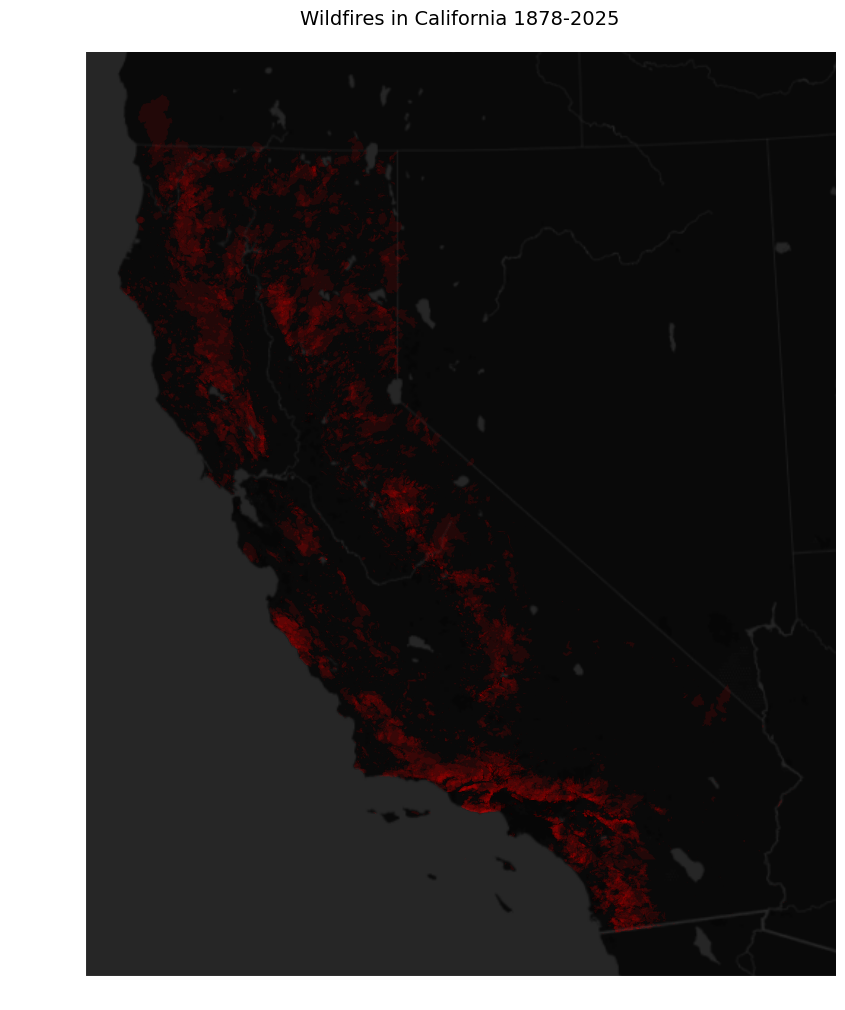

In [217]:
# Visualize all fires in dataset
fire_gdf.to_crs("EPSG:4326")
fig, ax = plt.subplots(figsize=(10, 12))
fire_gdf.plot(ax=ax, color='red', markersize=5, alpha=0.1)

# Add basemap
ctx.add_basemap(
    ax,
    crs=fire_gdf.crs,
    source=ctx.providers.CartoDB.DarkMatterNoLabels,
    attribution=False
)

# Style the plot with dark theme
ax.set_facecolor('#121212')
ax.set_title("Wildfires in California 1878-2025", 
             color='black', fontsize=14, pad=20)

# Customize spines and ticks
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.tick_params(colors='white')

plt.show()

In [58]:
# Convert timedelta to float before export for compatibility
fire_gdf['days_to_containment'] = fire_gdf['days_to_containment'].dt.days.astype(float)

In [59]:
fire_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 22810 entries, 0 to 22809
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   YEAR_                22733 non-null  float64            
 1   STATE                22810 non-null  object             
 2   AGENCY               22761 non-null  object             
 3   UNIT_ID              22749 non-null  object             
 4   FIRE_NAME            22748 non-null  object             
 5   INC_NUM              21839 non-null  object             
 6   IRWINID              3736 non-null   object             
 7   ALARM_DATE           17414 non-null  datetime64[ms, UTC]
 8   CONT_DATE            10180 non-null  datetime64[ms, UTC]
 9   C_METHOD             10708 non-null  float64            
 10  CAUSE                22810 non-null  int16              
 11  COMPLEX_NAME         611 non-null    object             
 12  COMPLEX_ID

In [60]:
# Export file
fire_gdf.to_csv(os.path.join(path, 'Prepared Data', 'wildfires_california.csv'), index=False)

In [62]:
fire_gdf.to_file(os.path.join(path, 'Prepared Data', 'wildfires_california.geojson'), driver='GeoJSON')

## Vegetation Data

In [8]:
# Get date as datetime
ndvi_df['date'] = pd.to_datetime(ndvi_df['date'])

In [9]:
ndvi_df = ndvi_df.merge(points, on=['longitude', 'latitude'])

In [10]:
ndvi_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541443 entries, 0 to 541442
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   date       541443 non-null  datetime64[ns]
 1   longitude  541443 non-null  float64       
 2   latitude   541443 non-null  float64       
 3   NDVI       541214 non-null  float64       
 4   EVI        541216 non-null  float64       
 5   point_id   541443 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 24.8 MB


In [11]:
ndvi_df[['NDVI', 'EVI']].describe()

,NDVI,EVI
count,541214.000000,541216.000000
mean,3517.337713,1964.063989
std,2124.637571,1098.259230
min,-1937.000000,-931.000000
25%,1439.000000,969.000000
50%,3388.000000,1849.000000
75%,5155.000000,2730.000000
max,9291.000000,7425.000000


In [12]:
ndvi_df.isna().sum()

date           0
longitude      0
latitude       0
NDVI         229
EVI          227
point_id       0
dtype: int64

In [114]:
nulls = ndvi_df[ndvi_df['NDVI'].isnull()]
nulls.groupby(['longitude','latitude', 'point_id'])['date'].count()

longitude    latitude   point_id
-123.748968  39.249091  19           14
-117.648828  33.449486  2302        160
-115.848846  33.349533  2999         19
-115.848843  33.249536  3000         34
-115.748844  33.249539  3033          1
-115.648845  33.249541  3065          1
Name: date, dtype: int64

In [115]:
# Filter and group
filtered = nulls[nulls['point_id'] != 2302]
filtered.groupby(['point_id', 'date'])['NDVI'].count().unstack('point_id')

point_id,19,2999,3000,3033,3065
date,,,,,
2015-01-01,NaN,NaN,NaN,NaN,0.0
2015-02-18,NaN,0.0,0.0,NaN,NaN
2015-06-10,NaN,NaN,0.0,NaN,NaN
2015-07-28,NaN,0.0,NaN,NaN,NaN
2015-08-13,NaN,NaN,0.0,NaN,NaN
2015-08-29,NaN,0.0,0.0,NaN,NaN
2015-09-14,NaN,0.0,NaN,NaN,NaN
2015-09-30,NaN,NaN,0.0,NaN,NaN
2015-10-16,NaN,0.0,NaN,NaN,NaN


In [13]:
ndvi_df = ndvi_df.sort_values(['point_id', 'date'])
ndvi_df = ndvi_df[ndvi_df['point_id'] != 2302]
ndvi_df = ndvi_df.fillna(method='ffill')
ndvi_df.isna().sum()

/tmp/ipykernel_27747/2818028621.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ndvi_df = ndvi_df.fillna(method='ffill')


date         0
longitude    0
latitude     0
NDVI         0
EVI          0
point_id     0
dtype: int64

In [136]:
dups = ndvi_df[ndvi_df.duplicated(subset=['NDVI', 'EVI'])]
dups.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89091 entries, 3334 to 511738
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       89091 non-null  datetime64[ns]
 1   longitude  89091 non-null  float64       
 2   latitude   89091 non-null  float64       
 3   NDVI       89091 non-null  object        
 4   EVI        89091 non-null  object        
 5   point_id   89091 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 4.8+ MB


In [18]:
# Complete date range
start_date = ndvi_df['date'].min()
end_date = df['date'].max()
complete_range = pd.date_range(start=start_date, end=end_date, freq='D')
print(complete_range[0], '-', complete_range.sort_values(ascending=False)[0])

2015-01-01 00:00:00 - 2021-12-31 00:00:00


In [19]:
# Find missing dates
missing_dates = complete_range.difference(ndvi_df['date'])
print(missing_dates.shape)
print(missing_dates)

(2396,)
DatetimeIndex(['2015-01-02', '2015-01-03', '2015-01-04', '2015-01-05',
               '2015-01-06', '2015-01-07', '2015-01-08', '2015-01-09',
               '2015-01-10', '2015-01-11',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=2396, freq=None)


In [20]:
# Set 'date' as index
ndvi_df = ndvi_df.set_index('date')

# Group by point_id
grouped = ndvi_df.groupby(['latitude', 'longitude'])

# Resample each group to daily frequency and forward-fill
resampled_dfs = []
for (lat, lon), group in grouped:
    # Resample to daily ('D') and forward-fill
    daily_group = group.resample('D').ffill()
    # Reset the index to get 'date' back as a column
    daily_group = daily_group.reset_index()
    # Add back the group keys (lat, lon)
    daily_group['latitude'] = lat
    daily_group['longitude'] = lon
    resampled_dfs.append(daily_group)

# Combine all resampled groups
ndvi_daily = pd.concat(resampled_dfs).sort_values(['date', 'latitude', 'longitude'])

In [22]:
print(ndvi_daily.info())
print(ndvi_daily.tail())

<class 'pandas.core.frame.DataFrame'>
Index: 8556290 entries, 0 to 2544
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   longitude  float64       
 2   latitude   float64       
 3   NDVI       float64       
 4   EVI        float64       
 5   point_id   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 457.0 MB
None
           date   longitude   latitude    NDVI     EVI  point_id
2544 2021-12-19 -121.449047  40.149119  2031.0  1277.0       567
2544 2021-12-19 -121.349048  40.149122  1688.0   983.0       610
2544 2021-12-19 -121.249050  40.149125  1688.0   983.0       654
2544 2021-12-19 -121.149051  40.149128  1808.0  1052.0       699
2544 2021-12-19 -121.049052  40.149131  1355.0   838.0       745


In [23]:
# Complete date range
start_date = ndvi_daily['date'].min()
end_date = df['date'].max()
complete_range = pd.date_range(start=start_date, end=end_date, freq='D')
print(complete_range[0], '-', complete_range.sort_values(ascending=False)[0])

2015-01-01 00:00:00 - 2021-12-31 00:00:00


In [24]:
# Find missing dates
missing_dates = complete_range.difference(ndvi_daily['date'])
print(missing_dates.shape)
print(missing_dates)

(12,)
DatetimeIndex(['2021-12-20', '2021-12-21', '2021-12-22', '2021-12-23',
               '2021-12-24', '2021-12-25', '2021-12-26', '2021-12-27',
               '2021-12-28', '2021-12-29', '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', freq='D')


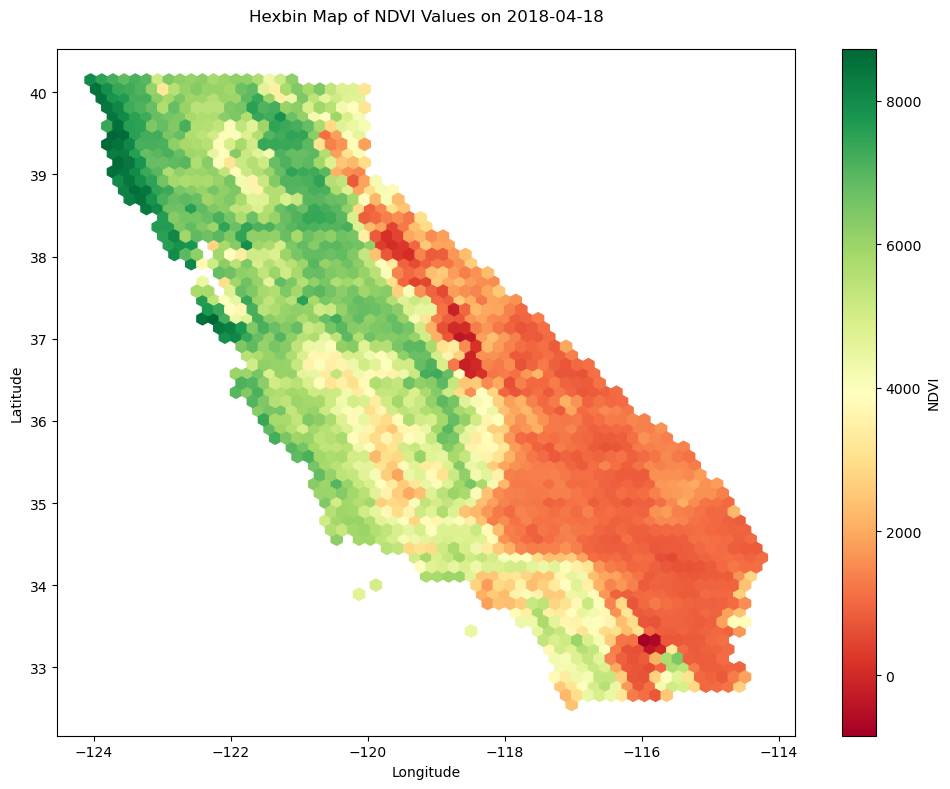

In [239]:
# Set test date
ndvi_test = ndvi_daily[ndvi_daily['date']=='2018-04-18']
ndvi_test.reset_index(drop=True)

# Create figure
plt.figure(figsize=(10, 8))

# Create hexbin plot
hb = plt.hexbin(
    x=ndvi_test['longitude'],
    y=ndvi_test['latitude'],
    C=ndvi_test['NDVI'],
    gridsize=60,
    cmap='RdYlGn',
    reduce_C_function=np.mean,  # Show average NDVI per hexagon
    mincnt=1  # Show hexagons with at least 1 point
)

# Add colorbar
cb = plt.colorbar(hb, label='NDVI')

# Customize plot
plt.title('Hexbin Map of NDVI Values on 2018-04-18', pad=20)
plt.xlabel('Longitude')
plt.ylabel('Latitude')

# Adjust layout and show
plt.tight_layout()
plt.show()

In [27]:
ndvi_daily.to_csv(os.path.join(path, 'Prepared Data', 'ndvi.csv'), index=False)

## Digital Elevation Model

In [129]:
dem_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3363 entries, 0 to 3362
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   aspect     3301 non-null   float64
 1   elevation  3363 non-null   int64  
 2   latitude   3363 non-null   float64
 3   longitude  3363 non-null   float64
 4   slope      3301 non-null   float64
dtypes: float64(4), int64(1)
memory usage: 131.5 KB


In [130]:
dem_df[['elevation', 'slope', 'aspect']].describe()

,elevation,slope,aspect
count,3363.000000,3301.000000,3301.000000
mean,790.294083,1.535786,181.593195
std,740.369900,1.426599,93.453390
min,-85.000000,0.004602,0.000000
25%,203.500000,0.524679,88.433855
50%,599.000000,1.191923,210.345781
75%,1132.500000,2.091202,251.713439
max,3607.000000,10.702813,359.032973


In [131]:
dem_dups = dem_df[dem_df.duplicated(subset=['aspect', 'elevation', 'slope'])]
dem_dups

,aspect,elevation,latitude,longitude,slope
1147,NaN,780,35.249480,-114.948921,NaN
1490,NaN,875,35.849437,-115.748935,NaN
2983,NaN,1897,39.149198,-120.049020,NaN
3251,NaN,3,39.949056,-123.948998,NaN


## Data Consolidation

In [152]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8599191 entries, 0 to 8693799
Data columns (total 17 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   date                               datetime64[ns]
 1   longitude                          float64       
 2   latitude                           float64       
 3   temperature_2m                     float64       
 4   temperature_2m_max                 float64       
 5   total_precipitation_sum            float64       
 6   dewpoint_temperature_2m            float64       
 7   volumetric_soil_water_layer_1      float64       
 8   surface_net_solar_radiation_sum    float64       
 9   surface_net_thermal_radiation_sum  float64       
 10  surface_sensible_heat_flux_sum     float64       
 11  potential_evaporation_sum          float64       
 12  total_evaporation_sum              float64       
 13  leaf_area_index_high_vegetation    float64       
 14  leaf_ar

In [160]:
ndvi_daily = ndvi_daily.drop(columns=['point_id'])

In [153]:
ndvi_daily.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8556290 entries, 0 to 2544
Data columns (total 6 columns):
 #   Column     Dtype         
---  ------     -----         
 0   date       datetime64[ns]
 1   longitude  float64       
 2   latitude   float64       
 3   NDVI       object        
 4   EVI        object        
 5   point_id   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(2)
memory usage: 457.0+ MB


In [161]:
merged = df.merge(ndvi_daily, on=['longitude', 'latitude', 'date'], how='left')

In [162]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599191 entries, 0 to 8599190
Data columns (total 19 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   date                               datetime64[ns]
 1   longitude                          float64       
 2   latitude                           float64       
 3   temperature_2m                     float64       
 4   temperature_2m_max                 float64       
 5   total_precipitation_sum            float64       
 6   dewpoint_temperature_2m            float64       
 7   volumetric_soil_water_layer_1      float64       
 8   surface_net_solar_radiation_sum    float64       
 9   surface_net_thermal_radiation_sum  float64       
 10  surface_sensible_heat_flux_sum     float64       
 11  potential_evaporation_sum          float64       
 12  total_evaporation_sum              float64       
 13  leaf_area_index_high_vegetation    float64       
 14  le

In [163]:
merged.isna().sum()

date                                     0
longitude                                0
latitude                                 0
temperature_2m                           0
temperature_2m_max                       0
total_precipitation_sum                  0
dewpoint_temperature_2m                  0
volumetric_soil_water_layer_1            0
surface_net_solar_radiation_sum          0
surface_net_thermal_radiation_sum        0
surface_sensible_heat_flux_sum           0
potential_evaporation_sum                0
total_evaporation_sum                    0
leaf_area_index_high_vegetation          0
leaf_area_index_low_vegetation           0
max_windspeed                            0
wind_direction                           0
NDVI                                 42901
EVI                                  42901
dtype: int64

In [164]:
merged2 = merged.merge(dem_df, on=['longitude', 'latitude'], how='left')

In [165]:
merged2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599191 entries, 0 to 8599190
Data columns (total 22 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   date                               datetime64[ns]
 1   longitude                          float64       
 2   latitude                           float64       
 3   temperature_2m                     float64       
 4   temperature_2m_max                 float64       
 5   total_precipitation_sum            float64       
 6   dewpoint_temperature_2m            float64       
 7   volumetric_soil_water_layer_1      float64       
 8   surface_net_solar_radiation_sum    float64       
 9   surface_net_thermal_radiation_sum  float64       
 10  surface_sensible_heat_flux_sum     float64       
 11  potential_evaporation_sum          float64       
 12  total_evaporation_sum              float64       
 13  leaf_area_index_high_vegetation    float64       
 14  le

In [166]:
merged2.isna().sum()

date                                      0
longitude                                 0
latitude                                  0
temperature_2m                            0
temperature_2m_max                        0
total_precipitation_sum                   0
dewpoint_temperature_2m                   0
volumetric_soil_water_layer_1             0
surface_net_solar_radiation_sum           0
surface_net_thermal_radiation_sum         0
surface_sensible_heat_flux_sum            0
potential_evaporation_sum                 0
total_evaporation_sum                     0
leaf_area_index_high_vegetation           0
leaf_area_index_low_vegetation            0
max_windspeed                             0
wind_direction                            0
NDVI                                  42901
EVI                                   42901
aspect                               158534
elevation                                 0
slope                                158534
dtype: int64

In [167]:
merged_final = merged2.merge(points, on=['longitude', 'latitude'], how='left')

In [168]:
merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599191 entries, 0 to 8599190
Data columns (total 23 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   date                               datetime64[ns]
 1   longitude                          float64       
 2   latitude                           float64       
 3   temperature_2m                     float64       
 4   temperature_2m_max                 float64       
 5   total_precipitation_sum            float64       
 6   dewpoint_temperature_2m            float64       
 7   volumetric_soil_water_layer_1      float64       
 8   surface_net_solar_radiation_sum    float64       
 9   surface_net_thermal_radiation_sum  float64       
 10  surface_sensible_heat_flux_sum     float64       
 11  potential_evaporation_sum          float64       
 12  total_evaporation_sum              float64       
 13  leaf_area_index_high_vegetation    float64       
 14  le

In [169]:
merged_final['point_id'] = merged_final['point_id'].astype(int)

In [170]:
merged_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599191 entries, 0 to 8599190
Data columns (total 23 columns):
 #   Column                             Dtype         
---  ------                             -----         
 0   date                               datetime64[ns]
 1   longitude                          float64       
 2   latitude                           float64       
 3   temperature_2m                     float64       
 4   temperature_2m_max                 float64       
 5   total_precipitation_sum            float64       
 6   dewpoint_temperature_2m            float64       
 7   volumetric_soil_water_layer_1      float64       
 8   surface_net_solar_radiation_sum    float64       
 9   surface_net_thermal_radiation_sum  float64       
 10  surface_sensible_heat_flux_sum     float64       
 11  potential_evaporation_sum          float64       
 12  total_evaporation_sum              float64       
 13  leaf_area_index_high_vegetation    float64       
 14  le

In [171]:
merged_final.to_csv(os.path.join(path, 'Prepared Data', 'all_features.csv'))